<a href="https://colab.research.google.com/github/jmasonlee/efficiently_testing_etl_pipelines/blob/main/fixing_a_big_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## STEP 0.A: Setup Notebook

In [11]:
!rm -rf efficiently_testing_etl_pipelines
!git clone https://github.com/jmasonlee/efficiently_testing_etl_pipelines.git
!cp -r /content/efficiently_testing_etl_pipelines/src/ .
!cp -r /content/efficiently_testing_etl_pipelines/tests/ .
!rm -rf efficiently_testing_etl_pipelines
!rm -rf tests/diamond_pricing_test*
!rm -rf tests/test_helpers/*verification_helpers.py
!rm -rf tests/conftest.py
!rm -rf sample_data


Cloning into 'efficiently_testing_etl_pipelines'...
remote: Enumerating objects: 687, done.
remote: Counting objects: 100% (328/328), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 687 (delta 210), reused 259 (delta 162), pack-reused 359
Receiving objects: 100% (687/687), 300.78 KiB | 1.60 MiB/s, done.
Resolving deltas: 100% (416/416), done.


# STEP 0.B: Setup Tests

### Install Dependencies

For the exercise, we will need some special dependencies to allow us to run lots of tests in a notebook.

`ipytest` lets us run our tests in a notebook.



In [12]:
!pip install ipytest

ipytest is what allows us to run our tests in a notebook. This next cell is not needed if you are writing tests in a separate pytest file.

In [13]:
import ipytest
ipytest.autoconfig()

We are installing `pyspark` because it doesn't come with the base colab environment

In [14]:
!pip install pyspark

In [15]:
!pip install chispa

## Create a local SparkSession

Normally spark runs on a bunch of executors in the cloud. Since we want our tests to be able to run on a single dev machine, we make a fixture that gives us a local spark context.

In [16]:
import pytest
from _pytest.fixtures import FixtureRequest
from pyspark import SparkConf
from pyspark.sql import SparkSession

@pytest.fixture(scope="session")
def spark(request: FixtureRequest):
    conf = (SparkConf()
        .setMaster("local")
        .setAppName("sample_pyspark_testing_starter"))

    spark = SparkSession \
        .builder \
        .config(conf=conf) \
        .getOrCreate()

    request.addfinalizer(lambda: spark.stop())
    return spark

## Create Helpers

This is a helper function that retrieves our test output from the expected.json file

In [17]:
import json
from typing import List, Dict

from pyspark.pandas import DataFrame


def create_df_from_json(json_file, spark):
    return spark.read.option("multiline", "true").json(json_file)


def data_frame_to_json(df: DataFrame) -> List:
    output = [json.loads(item) for item in df.toJSON().collect()]
    output.sort(key=lambda item: item["id"])
    print(output)
    return output

def expected_json(name: str) -> Dict:
    with open(f"tests/fixtures/{name}") as f:
        return json.loads(f.read())

In [18]:
import pyspark
def build_indep_vars(df, independent_vars, categorical_vars=None, keep_intermediate=False, summarizer=True):
    check_input(categorical_vars, df, independent_vars)

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    idx = 'index'
    vec = 'vector'
    if categorical_vars:
        string_indexer = [StringIndexer(inputCol=x,
                                        outputCol=f"{x}_{idx}")
                          for x in categorical_vars]

        encoder        = [OneHotEncoder(dropLast=True,
                                        inputCol =f'{x}_{idx}',
                                        outputCol=f'{x}_{vec}')
                          for x in categorical_vars]

        independent_vars = ['{}_vector'.format(x) if x in categorical_vars else x for x in independent_vars]
    else:
        string_indexer, encoder = [], []

    assembler = VectorAssembler(inputCols=independent_vars,
                                outputCol='indep_vars')
    pipeline  = Pipeline(stages=string_indexer+encoder+[assembler])
    model = pipeline.fit(df)
    df = model.transform(df)

    if not keep_intermediate:
        fcols = [c for c in df.columns if f'_{idx}' not in c[-3:] and f'_{vec}' not in c[-7:]]
        df = df[fcols]

    return df


def check_input(categorical_vars, df, independent_vars):
    assert (type(
        df) is pyspark.sql.dataframe.DataFrame), 'pypark_glm: A pySpark dataframe is required as the first argument.'
    assert (type(
        independent_vars) is list), 'pyspark_glm: List of independent variable column names must be the third argument.'
    for iv in independent_vars:
        assert (type(iv) is str), 'pyspark_glm: Independent variables must be column name strings.'
        assert (iv in df.columns), 'pyspark_glm: Independent variable name is not a dataframe column.'
    if categorical_vars:
        for cv in categorical_vars:
            assert (type(cv) is str), 'pyspark_glm: Categorical variables must be column name strings.'
            assert (cv in df.columns), 'pyspark_glm: Categorical variable name is not a dataframe column.'
            assert (cv in independent_vars), 'pyspark_glm: Categorical variables must be independent variables.'


In [19]:
from pyspark.sql import DataFrame, Window, Column
from pyspark.sql.functions import log, when, mean, col

def replace_null(orig: Column, average: Column):
    return when(orig.isNull(), average).otherwise(orig)

def transform(df: DataFrame) -> DataFrame:

    df = df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    df = build_indep_vars(df, ['carat', 'clarity', 'color'],
                                      categorical_vars=['clarity', 'color'],
                                      keep_intermediate=False,
                                      summarizer=True)
    return df

# STEP 1: Investigate The Test

In [20]:
%%ipytest -qq
from pyspark.sql import SparkSession

def test_will_do_the_right_thing(spark: SparkSession):
    #ARRANGE - SET UP TEST INPUTS
    diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    #ACT - RUN THE CODE WE ARE TESTING
    actual_df = transform(diamonds_df)

    #ASSERT - CHECK THE OUTPUTS ARE CORRECT
    assert data_frame_to_json(actual_df) == expected_json("expected.json")

.                                                                                            [100%]


# Step 1: Setup For the Saff Squeeze

Let's get ready to improve the test.

**our bug**: Diamonds of the same cut and clarity are influencing the calculated price of diamonds with a different color. Only diamonds with the same cut, clarity _**and color**_ should be influencing the calculated price for diamonds with a null price.

## STEP 1A - Test for the desired behaviour
- [ ] There is a second json file (`expected_correct.json`) where the expected price for the unpriced diamond has been updated to the correct value. Use that file name as the argument passed to `expected_json`
- [ ] Run the test. It should fail.

In [21]:
%%ipytest -qq
from pyspark.sql import SparkSession

def test_will_do_the_right_thing(spark: SparkSession):
    diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(diamonds_df)

    assert data_frame_to_json(actual_df) == expected_json("expected.json")  # <- Rename the "expected.json" file to "expected_correct.json"

.                                                                                            [100%]


## STEP 1B - Duplicate the test

- [ ] Duplicate the test. Now you should have two copies of the same test.
  * One copy will stay the same, so we can make sure that nothing is broken.
  * The second copy is what we will change in the next steps.
- [ ] Name the second test
```
test_null_price_is_replaced_based_on_cut_clarity_and_color
```
- [ ] Run the tests. They should both fail.

In [ ]:
%%ipytest -qq
from pyspark.sql import SparkSession


# Duplicate the test below and rename the duplicate to:
# test_null_price_is_replaced_based_on_cut_clarity_and_color

########################## START OF THE ORIGINAL TEST ##########################
def test_will_do_the_right_thing(spark: SparkSession):
    diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(diamonds_df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")
########################### END OF THE ORIGINAL TEST ###########################

.                                                                                            [100%]


#STEP 1C - Temporarily disable the original test
- [ ] Mark the failing test with `@pytest.mark.skip()` to make our output less confusing.
- [ ] Run the tests. You should see this in your cell output:
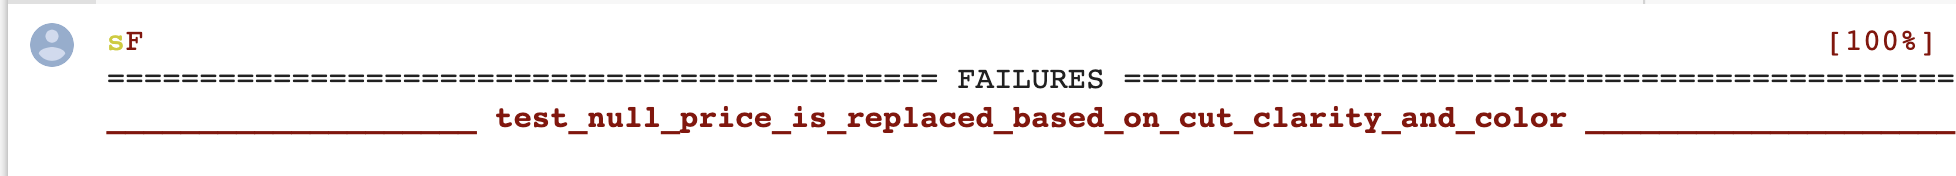

The lowercase $\color{goldenrod}{\text{s}}$$\color{red}{\text{F}}$
indicates that two tests were run. One test ($\color{goldenrod}{\text{s}}$) was skipped. The other test ($\color{red}{\text{F}}$) failed.

Immediately below the FAILURES line, you should see the name of the test that failed, in red. It is the test we are changing:
$\color{red}{\text{____________________ test_null_price_is_replaced_based_on_cut_clarity_and_color ____________________}}$




In [23]:
%%ipytest -qq
import pytest # <- UNCOMMENT THIS LINE

from pyspark.sql import SparkSession


@pytest.mark.skip()
def test_will_do_the_right_thing(spark: SparkSession):
    diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(diamonds_df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(diamonds_df)

    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")

sF                                                                                           [100%]
============================================= FAILURES =============================================
____________________ test_null_price_is_replaced_based_on_cut_clarity_and_color ____________________

spark = <pyspark.sql.session.SparkSession object at 0x78529b901ed0>

    def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
        diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)
    
        actual_df = transform(diamonds_df)
    
>       assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")
E       AssertionError: assert [{'carat': 0....G', ...}, ...] == [{'carat': 0....G', ...}, ...]
E         At index 1 diff: {'id': 'DI-26', 'carat': 0.21, 'clarity': 'VVS1', 'color': 'D', 'price': 3333.0, 'clarity_index': 0.0, 'color_index': 0.0, 'indep_vars': {'type': 0, 'size': 7, 'indices': [0, 1, 4], 'values': [0.

# Step 2: Make The Assert Specific

Right now, our test compares everything in the output dataframe to everything in a large json file. That's a lot of rows to compare and the assert is wrong anyways!

Let's make this test assert on the thing we actually care about - the output price of the diamond!

## Instructions - Chispa

#### With Chispa
- [ ] Add these imports to the top of the cell, below the `%%ipytest -qq` line:  
`from chispa import assert_column_equality`  
`from pySpark.sql.functions import lit`
- [ ] Filter the dataframe for the unique id of the diamond we care about:  
`actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')`
- [ ] Create a new column in our dataframe that contains our expected price:  
`actual_df=actual_df.withColumn('expected_price', lit(3333.0))`
- [ ] Assert the value in the price column matches the value we want:  
`assert_column_equality(actual_df, 'price', 'expected_price')`


## Exercise - Chispa

In [ ]:
%%ipytest -qq
from pyspark.sql import SparkSession


def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(diamonds_df)


.                                                                                            [100%]


### Instructions - Pandas
- [ ] import pandas:  
`import pandas as pd`
- [ ] Filter the dataframe for the unique id of the diamond we care about:  
  `actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')`
- [ ] Create your expected dataframe using Pandas:  
 `expected = pd.DataFrame(({'id': ["DI-26-null-price"], 'price':[3333.0] }))`
- [ ] Select the column you care about:  
  `actual_df=actual_df.select(['id', 'price'])
- [ ] Assert for dataframe equality using pandas:  
  `pd.testing.assert_frame_equal(actual_df, expected)`

## Exercise - Pandas

In [ ]:
%%ipytest -qq
from pyspark.sql import SparkSession


def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(diamonds_df)


.                                                                                            [100%]


### Instructions - JSON properties

- [ ] Filter the dataframe for the unique id of the diamond we care about:  
  `actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')`
- [ ] Convert your dataframe to JSON:  
`actual_df_json = data_frame_to_json(actual_df)`
- [ ] Assert the price property of the first object matches your expected price:  
`assert actual_df_json[0]['price'] == 3333.0`

## Exercise - JSON properties

In [ ]:
%%ipytest -qq
from pyspark.sql import SparkSession


def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(diamonds_df)



.                                                                                            [100%]


# Step 3: Reduce Duplicate Coverage and Fix the Bug

Right now, our test is running the entire transform function. Because there are multiple tests in `diamonds.json`, each test is running the same large block of code over and over again.

## STEP 3.A: Prep

### Instructions
Let's get ready to reduce the duplicate coverage.

#### 1. Put the transform function where you can work with it
- [ ] Run the test. It should be failing.
- [ ] Replace the call to the transform function with the body of that function.
- [ ] Change the last line of the function body to assign to `actual_df` instead of `df`
```
df = build_indep_vars(df, ['carat', 'clarity', 'color'],
                                      categorical_vars=['clarity', 'color'],
                                      keep_intermediate=False,
                                      summarizer=True)
```
becomes
```
actual_df = build_indep_vars(df, ['carat', 'clarity', 'color'],
                                      categorical_vars=['clarity', 'color'],
                                      keep_intermediate=False,
                                      summarizer=True)
```
- [ ] Change the first line of the function body to read from `diamonds_df` instead of `df`
```
 df = df.withColumn('lprice', log('price'))
```
becomes
```
 df = diamonds_df.withColumn('lprice', log('price'))
```
- [ ] Run the test. It should still be failing for the same reasons.

#### 2. Test FOR the bug
- [ ] Change your assert code so that it is testing _for_ the bug.
```
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
```
becomes
```
  actual_df=actual_df.withColumn('expected_price', lit(2460.0))
```
- [ ] Run the test. It should pass.

#### 3. Make the assert easier to work with
- [ ] Extract your assert code into a one-line helper function:
```
def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')
    actual_df=actual_df.withColumn('expected_price', lit(2460.0))
    assert_column_equality(actual_df, 'price', 'expected_price')
```
- [ ] Run the test. It should pass.

### Exercise

#### The Code

##### The `transform` Function

In [ ]:
from pyspark.sql import DataFrame, Window, Column
from pyspark.sql.functions import log, when, mean, col

def transform(df: DataFrame) -> DataFrame:
# The body of the transform function STARTS HERE
    df = df.withColumn('lprice', log('price'))  #<-- In the test, this line should be: df = diamonds_df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    df = build_indep_vars(df, ['carat', 'clarity', 'color'], #<-- In the test, this line should be: actual_df = build_indep_vars(df, ['carat', 'clarity', 'color']
                                      categorical_vars=['clarity', 'color'],
                                      keep_intermediate=False,
                                      summarizer=True)
# The body of the transform function ENDS HERE
    return df

#### The Test

In [ ]:
%%ipytest -qq
from pyspark.sql import SparkSession

def test_prep_for_linear_regression(spark: SparkSession):
    diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(diamonds_df) #<-- We will be replacing this line with the body of the transform function

    actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

F                                                                                            [100%]
============================================= FAILURES =============================================
_________________________________ test_prep_for_linear_regression __________________________________

spark = <pyspark.sql.session.SparkSession object at 0x78015abc36d0>

    def test_prep_for_linear_regression(spark: SparkSession):
        diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)
    
        actual_df = transform(diamonds_df) #<-- We will be replacing this line with the body of the transform function
    
        actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')
        actual_df=actual_df.withColumn('expected_price', lit(3333.0))
>       assert_column_equality(actual_df, 'price', 'expected_price')

<ipython-input-68-c6ea0e31b630>:10: 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

df = D

#### The original test



In [ ]:
%%ipytest -qq
from pyspark.sql import SparkSession

def test_will_do_the_right_thing(spark: SparkSession):
    diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(diamonds_df)
    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")

F                                                                                            [100%]
============================================= FAILURES =============================================
___________________________________ test_will_do_the_right_thing ___________________________________

spark = <pyspark.sql.session.SparkSession object at 0x78015ab7cf10>

    def test_will_do_the_right_thing(spark: SparkSession):
        diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)
    
        actual_df = transform(diamonds_df)
>       assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")
E       AssertionError: assert [{'carat': 0....G', ...}, ...] == [{'carat': 0....G', ...}, ...]
E         At index 1 diff: {'id': 'DI-26', 'carat': 0.21, 'clarity': 'VVS1', 'color': 'D', 'price': 3333.0, 'clarity_index': 0.0, 'color_index': 0.0, 'indep_vars': {'type': 0, 'size': 7, 'indices': [0, 1, 4], 'values': [0.21, 1.0, 1.0]}} != {'id': 'DI-26', 

## Step 3.B Squeeze the bottom!



### Instructions
**our bug**: Diamonds of the same cut and clarity are influencing the calculated price of diamonds with a different color. Only diamonds with the same cut, clarity and color should be influencing the calculated price for diamonds with a null price.

**Squeeze the bottom until you find the bug**
- [ ] Move your assert up one line at a time.  
- [ ] After each move, run your test.  
- [ ] If it fails, figure out why it's failing.(You may need to rename columns in the assert)
- [ ] If the test passes, the line wasn't important for the bug you wanted to catch. Delete it.
- [ ] Continue until you find the source of the bug

### Exercise

#### The Code

##### The `transform` Function

In [ ]:
from pyspark.sql import DataFrame, Window, Column
from pyspark.sql.functions import log, when, mean, col

def transform(df: DataFrame) -> DataFrame:

    df = df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    df = build_indep_vars(df, ['carat', 'clarity', 'color'],
                                      categorical_vars=['clarity', 'color'],
                                      keep_intermediate=False,
                                      summarizer=True)
    return df

#### The Test

In [ ]:
%%ipytest -qq
from pyspark.sql import SparkSession, DataFrame, Window, Column
from pyspark.sql.functions import lit, log, when, mean, col
from chispa import assert_column_equality

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')
    actual_df=actual_df.withColumn('expected_price', lit(2460.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    df = diamonds_df.withColumn('lprice', log('price'))
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    actual_df = build_indep_vars(df, ['carat', 'clarity', 'color'],
                                      categorical_vars=['clarity', 'color'],
                                      keep_intermediate=False,
                                      summarizer=True)

    assert_diamond_has_expected_price(actual_df)







F                                                                                            [100%]
============================================= FAILURES =============================================
____________________ test_null_price_is_replaced_based_on_cut_clarity_and_color ____________________

spark = <pyspark.sql.session.SparkSession object at 0x78015ad21450>

    def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
        diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)
    
        df = diamonds_df.withColumn('lprice', log('price'))
        window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
        moving_avg = mean(df['price']).over(window)
        df = df.withColumn('moving_avg', moving_avg)
    
        df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
        df = df[['id', 'carat', 'clarity', 'color', 'price']]
        actual_df = build_indep_var

#### The Original Test

In [ ]:
%%ipytest -qq
from pyspark.sql import SparkSession

def test_will_do_the_right_thing(spark: SparkSession):
    diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(diamonds_df)
    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")

F                                                                                            [100%]
============================================= FAILURES =============================================
___________________________________ test_will_do_the_right_thing ___________________________________

spark = <pyspark.sql.session.SparkSession object at 0x78015ae0d390>

    def test_will_do_the_right_thing(spark: SparkSession):
        diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)
    
        actual_df = transform(diamonds_df)
>       assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")
E       AssertionError: assert [{'carat': 0....G', ...}, ...] == [{'carat': 0....G', ...}, ...]
E         At index 1 diff: {'id': 'DI-26', 'carat': 0.21, 'clarity': 'VVS1', 'color': 'D', 'price': 3333.0, 'clarity_index': 0.0, 'color_index': 0.0, 'indep_vars': {'type': 0, 'size': 7, 'indices': [0, 1, 4], 'values': [0.21, 1.0, 1.0]}} != {'id': 'DI-26', 

## Step 3.C Let's fix the bug!


### Instructions

**Our Bug**: Diamonds of the same cut and clarity are influencing the calculated price of diamonds with a different color. Only diamonds with the same cut, clarity and color should be influencing the calculated price for diamonds with a null price.

**Our Desired Behaviour**:  
The input diamond with these properties:
- id: `"DI-26-null-price"`
- cut: `"Good"`
- color: `"D"`
- clarity: `"VVS1"`
- price: `null`

Should be output with a price of `3333.0` - the average price of the other diamonds with `cut="Good"`, `clarity="VVS1"` and `color="D"`

**Fix the bug**
#### Test for the behaviour you actually want
- [ ] Update your test so that it checks for the good behaviour.  
Replace the expected price on this line with `3333.0`:  
```
actual_df=actual_df.withColumn('expected_price', lit(2460.0))
```
- [ ] Run your test. It should fail with a `columnsNotEqualError`:  
```
E           chispa.column_comparer.ColumnsNotEqualError:
E           +------------+----------------+
E           | moving_avg | expected_price |
E           +------------+----------------+
E           |   2460.0   |     3333.0     |
E           +------------+----------------+
```

#### Fix the bug
- [ ] Fix the code _in your test_ so that the bug is gone. We need to add `'color'` to `'cut'` and `'clarity'` on this line:
```
window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
```
- [ ] Run your test. It should pass.

#### Encapsulate the code necessary for the behaviour
- [ ] The behaviour belongs to a group of lines working together. Extract them into a method.  
These lines can't be separated without changing the behaviour we are testing:  
```
    window = Window.partitionBy('cut', 'clarity', 'color').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
```  
Use them to make a method:
```
def calculate_avg_price_for_similar_diamonds(df: DataFrame) -> DataFrame:
      window = Window.partitionBy('cut', 'clarity', 'color').orderBy('price').rowsBetween(-3, 3)
      moving_avg = mean(df['price']).over(window)
      df = df.withColumn('moving_avg', moving_avg)
      df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
      return df
```

Replace those lines with a call to the new method in your test:  
```
actual_df = calculate_avg_price_for_similar_diamonds(actual_df)
```
- [ ] Run your test. It should pass.

#### Move the encapsulated behaviour to the actual code
- [ ] Move the new method out of your test and into the transform code.
- [ ] Replace the lines in your transform code with the new method call.
- [ ] We've changed the original code, so we need to check that everything still works the way we expect. Run the copy of your original large test. It should also pass.
- [ ] Run your test. It should pass.


### Exercise

#### The Code

##### The `transform` Function

In [ ]:
from pyspark.sql import DataFrame, Window, Column
from pyspark.sql.functions import log, when, mean, col


def transform(df: DataFrame) -> DataFrame:

    df = df.withColumn('lprice', log('price'))
    #THIS IS WHERE THE BEHAVIOUR WE CARE ABOUT STARTS - REPLACE THIS BLOCK
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)

    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    #THIS IS WHERE THE BEHAVIOUR WE CARE ABOUT ENDS - REPLACE THIS BLOCK
    df = df[['id', 'carat', 'clarity', 'color', 'price']]
    df = build_indep_vars(df, ['carat', 'clarity', 'color'],
                                      categorical_vars=['clarity', 'color'],
                                      keep_intermediate=False,
                                      summarizer=True)
    return df

#### The Test

In [ ]:
%%ipytest -qq
from pyspark.sql import SparkSession, DataFrame, Window, Column
from pyspark.sql.functions import lit, log, when, mean, col
from chispa import assert_column_equality

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')
    actual_df=actual_df.withColumn('expected_price', lit(2460.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    df = diamonds_df.withColumn('lprice', log('price'))

    #THIS IS WHERE THE BEHAVIOUR WE CARE ABOUT STARTS - EXTRACT THIS BLOCK
    window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    #THIS IS WHERE THE BEHAVIOUR WE CARE ABOUT ENDS

    assert_diamond_has_expected_price(df)





F                                                                                            [100%]
============================================= FAILURES =============================================
____________________ test_null_price_is_replaced_based_on_cut_clarity_and_color ____________________

spark = <pyspark.sql.session.SparkSession object at 0x78015aa9e4d0>

    def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
        diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)
    
        df = diamonds_df.withColumn('lprice', log('price'))
    
        #THIS IS WHERE THE BEHAVIOUR WE CARE ABOUT STARTS - EXTRACT THIS BLOCK
        window = Window.partitionBy('cut', 'clarity').orderBy('price').rowsBetween(-3, 3)
        moving_avg = mean(df['price']).over(window)
        df = df.withColumn('moving_avg', moving_avg)
        df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
        #THIS IS W

#### The Original Test

In [ ]:
%%ipytest -qq
from pyspark.sql import SparkSession

def test_will_do_the_right_thing(spark: SparkSession):
    diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = transform(diamonds_df)
    assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")

F                                                                                            [100%]
============================================= FAILURES =============================================
___________________________________ test_will_do_the_right_thing ___________________________________

spark = <pyspark.sql.session.SparkSession object at 0x78015a824160>

    def test_will_do_the_right_thing(spark: SparkSession):
        diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)
    
        actual_df = transform(diamonds_df)
>       assert data_frame_to_json(actual_df) == expected_json("expected_correct.json")
E       AssertionError: assert [{'carat': 0....G', ...}, ...] == [{'carat': 0....G', ...}, ...]
E         At index 1 diff: {'id': 'DI-26', 'carat': 0.21, 'clarity': 'VVS1', 'color': 'D', 'price': 3333.0, 'clarity_index': 0.0, 'color_index': 0.0, 'indep_vars': {'type': 0, 'size': 7, 'indices': [0, 1, 4], 'values': [0.21, 1.0, 1.0]}} != {'id': 'DI-26', 

# Step 4: Simplify the Top

We don't want our test to be reading in the entire diamonds.json file in order to test this single behaviour. We are going to simplify things so that we have the absolute minimum number of inputs we need to reproduce the behaviour.

Instead of reading from a large JSON file directly, we can make a dataframe with only the values we need in order to reproduce the behaviour

**our bug**: Diamonds of the same cut and clarity are influencing the calculated price of diamonds with a different color. Only diamonds with the same cut, clarity and color should be influencing the calculated price for diamonds with a null price.

**expected behaviour**: An unpriced diamond with cut=Good, color=D and clarity=VVS1 in a dataset with other diamonds of the same cut, clarity and color all priced at 3333.0, will have it's price set to match the average price of those diamonds. It will ignore prices from diamonds with a different color, cut or clarity

4A. We are going to be changing our test inputs. let's make sure the ones we need are present.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame, Window
from pyspark.sql.functions import lit, log, when, mean
from chispa import assert_column_equality

### FOR REFERENCE: THIS IS THE CODE WE ARE TESTING #############################
def calculate_avg_price_for_similar_diamonds(df: DataFrame) -> DataFrame:
    window = Window.partitionBy('cut', 'clarity', 'color').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    return df
################################################################################


def check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df):
    # print("ACTUAL DATAFRAME:")
    # actual_df.show()
    actual_df = actual_df.select('id', 'cut', 'clarity', 'color')
    # print("ACTUAL DATAFRAME(IMPORTANT COLUMNS):")
    # actual_df.show()

    wrong_color_df = actual_df.filter((actual_df.cut == 'Good') & (actual_df.clarity == 'VVS1') & (actual_df.color != 'D'))
    # print("WRONG COLOR DATAFRAME:")
    # wrong_color_df.show()
    assert wrong_color_df.count() >= 1
    # assert False


def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df)
    actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark)

    actual_df = diamonds_df.withColumn('lprice', log('price'))  # <-- Delete this line
    actual_df = calculate_avg_price_for_similar_diamonds(actual_df) # <-- Change this line to: actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)


.                                                                                            [100%]


#### 4.B Create the minimum Inputs needed to reproduce the bug
- [ ] Delete the line that reads in from diamonds.json
- [ ] Replace it with two lines, one that parses the json text file to a string, and the other that converts the json string to spark


In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

### FOR REFERENCE: THIS IS THE CODE WE ARE TESTING #############################
def calculate_avg_price_for_similar_diamonds(df: DataFrame) -> DataFrame:
    window = Window.partitionBy('cut', 'clarity', 'color').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    return df
################################################################################


def check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df):
    actual_df = actual_df.select('id', 'cut', 'clarity', 'color')

    wrong_color_df = actual_df.filter((actual_df.cut == 'Good') & (actual_df.clarity == 'VVS1') & (actual_df.color != 'D'))
    assert wrong_color_df.count() >= 1

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df)
    actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = create_df_from_json("tests/fixtures/diamonds.json", spark) # <- Delete this line

    #json_text = Path("./tests/fixtures/diamonds.json").read_text()
    #diamonds_df = spark.read.option("multiline", "true").json(spark.sparkContext.parallelize([json_text]))

    actual_df = diamonds_df.withColumn('lprice', log('price'))
    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)

.                                                                                            [100%]


4C. Create the minimum Inputs needed to reproduce the bug
- [ ] Copy the contents of `tests/fixtures/diamonds.json` to a multiline string.
- [ ] Delete the line that reads the input data from a file
- [ ] Run your test. It should pass.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from pathlib import Path

### FOR REFERENCE: THIS IS THE CODE WE ARE TESTING #############################
def calculate_avg_price_for_similar_diamonds(df: DataFrame) -> DataFrame:
    window = Window.partitionBy('cut', 'clarity', 'color').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    return df
################################################################################

def check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df):
    actual_df = actual_df.select('id', 'cut', 'clarity', 'color')

    wrong_color_df = actual_df.filter((actual_df.cut == 'Good') & (actual_df.clarity == 'VVS1') & (actual_df.color != 'D'))
    assert wrong_color_df.count() >= 1

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df)
    actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    json_text = '''
      PASTE CONTENTS OF tests/fixtures/diamonds.json HERE
    '''
    json_text = Path("./tests/fixtures/diamonds.json").read_text()  # <- DELETE THIS LINE
    diamonds_df = spark.read.option("multiline", "true").json(spark.sparkContext.parallelize([json_text]))

    actual_df = diamonds_df.withColumn('lprice', log('price'))
    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)

.                                                                                            [100%]


4D. Squeeze the inputs
- [ ] Run your test. It should pass.
- [ ] Delete the objects from the JSON array one at a time.
- [ ] After each deletion, run your test. If it fails, undo the delete
- [ ] Move onto the next object
- [ ] At the end, you should have the minimum objects needed for our test to test the behaviour

**VERY IMPORTANT:** Your test will fail for the wrong reasons if the JSON array ends in a comma.

Make sure the last 4 lines of the array always look like this:
```
    "z": null
  }
]
    '''
 ```

NOT this:
```
    "z": null
  },
]
    '''
```

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from pathlib import Path

### FOR REFERENCE: THIS IS THE CODE WE ARE TESTING #############################
def calculate_avg_price_for_similar_diamonds(df: DataFrame) -> DataFrame:
    window = Window.partitionBy('cut', 'clarity', 'color').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    return df
################################################################################

def check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df):
    actual_df = actual_df.select('id', 'cut', 'clarity', 'color')

    wrong_color_df = actual_df.filter((actual_df.cut == 'Good') & (actual_df.clarity == 'VVS1') & (actual_df.color != 'D'))
    assert wrong_color_df.count() >= 1

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df)
    actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    json_text = '''
[
  {
    "id": 1,
    "carat": 0.23,
    "cut": "Ideal",
    "color": "E",
    "clarity": "SI2",
    "depth": 61.5,
    "table": 55,
    "price": 326,
    "x": 3.95,
    "y": 3.98,
    "z": 2.43
  },
  {
    "id": "minimum_inputs",
    "carat": 0.23,
    "cut": "Good",
    "color": "F",
    "clarity": "SI1",
    "depth": null,
    "table": null,
    "price": null,
    "x": null,
    "y": null,
    "z": null
  },
  {
    "id": "DI-26-null-price",
    "carat": 0.21,
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "depth": null,
    "table": null,
    "price": null,
    "x": null,
    "y": null,
    "z": null
  },
  {
    "id": "DI-26",
    "carat": 0.21,
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "depth": null,
    "table": null,
    "price": 3333,
    "x": null,
    "y": null,
    "z": null
  },
  {
    "id": "DI-26",
    "carat": 0.21,
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "depth": null,
    "table": null,
    "price": 3333,
    "x": null,
    "y": null,
    "z": null
  },
  {
    "id": "DI-27",
    "carat": 0.21,
    "cut": "Very Good",
    "color": "D",
    "clarity": "VVS1",
    "depth": null,
    "table": null,
    "price": 2692,
    "x": null,
    "y": null,
    "z": null
  },
  {
    "id": "DI-30",
    "carat": 0.32,
    "cut": "Good",
    "color": "D",
    "clarity": "I1",
    "depth": 60.9,
    "table": 58,
    "price": 345,
    "x": 4.38,
    "y": 4.42,
    "z": 2.68
  },
  {
    "id": "DI-28",
    "carat": 0.21,
    "cut": "Good",
    "color": "G",
    "clarity": "VVS1",
    "depth": null,
    "table": null,
    "price": 1665,
    "x": null,
    "y": null,
    "z": null
  }
]
    '''

    diamonds_df = spark.read.option("multiline", "true").json(spark.sparkContext.parallelize([json_text]))

    actual_df = diamonds_df.withColumn('lprice', log('price'))
    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)

.                                                                                            [100%]


4E. Squeeze the inputs
- [ ] Run your test. It should pass.
- [ ] Delete the properties from each JSON object one at a time.
- [ ] After each deletion, run your test. If it fails, undo the delete
- [ ] Move onto the next property
- [ ] At the end, you should have the minimum objects and properties needed for our test to test the behaviour
- [ ] Run your test. It should pass.

**VERY IMPORTANT:** Your test will fail for the wrong reasons if the last property in any JSON object ends in a comma.

Make sure the last property of each object always looks like this:
```
    "z": null
  }
 ```

NOT this:
```
    "z": null,
  }
```

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from pathlib import Path

### FOR REFERENCE: THIS IS THE CODE WE ARE TESTING #############################
def calculate_avg_price_for_similar_diamonds(df: DataFrame) -> DataFrame:
    window = Window.partitionBy('cut', 'clarity', 'color').orderBy('price').rowsBetween(-3, 3)
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    return df
################################################################################

def check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df):
    actual_df = actual_df.select('id', 'cut', 'clarity', 'color')

    wrong_color_df = actual_df.filter((actual_df.cut == 'Good') & (actual_df.clarity == 'VVS1') & (actual_df.color != 'D'))
    assert wrong_color_df.count() >= 1

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df)
    actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    json_text = '''
[
  {
    "id": "DI-26-null-price",
    "carat": 0.21,
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "depth": null,
    "table": null,
    "price": null,
    "x": null,
    "y": null,
    "z": null
  },
  {
    "id": "DI-26",
    "carat": 0.21,
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "depth": null,
    "table": null,
    "price": 3333,
    "x": null,
    "y": null,
    "z": null
  },
  {
    "id": "DI-28",
    "carat": 0.21,
    "cut": "Good",
    "color": "G",
    "clarity": "VVS1",
    "depth": null,
    "table": null,
    "price": 1665,
    "x": null,
    "y": null,
    "z": null
  }
]
    '''

    diamonds_df = spark.read.option("multiline", "true").json(spark.sparkContext.parallelize([json_text]))

    actual_df = diamonds_df.withColumn('lprice', log('price'))
    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)

.                                                                                            [100%]



#### 4.F Remove lines that aren't related to the behaviour
- [ ] Delete:

```
actual_df = diamonds_df.withColumn('lprice', log('price'))
```
- [ ] Update the name of the parameter we pass to `calculate_avg_price_for_similar_diamonds` from `actual_df` to `diamonds_df`
- [ ] Run your test. It should pass. This means that line wasn't important for our behaviour.



In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from pathlib import Path

### FOR REFERENCE: THIS IS THE CODE WE ARE TESTING #############################
def calculate_avg_price_for_similar_diamonds(df: DataFrame) -> DataFrame:
    window = Window.partitionBy('cut', 'clarity', 'color').orderBy('price').rowsBetween(-3, 3)  #<- Remove cut or clarity from this line.
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    return df
################################################################################

def check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df):
    actual_df = actual_df.select('id', 'cut', 'clarity', 'color')

    wrong_color_df = actual_df.filter((actual_df.cut == 'Good') & (actual_df.clarity == 'VVS1') & (actual_df.color != 'D'))
    assert wrong_color_df.count() >= 1

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df)
    actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    json_text = '''
[
  {
    "id": "DI-26-null-price",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": null
  },
  {
    "id": "DI-26",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": 3333
  },
  {
    "id": "DI-28",
    "cut": "Good",
    "color": "G",
    "clarity": "VVS1",
    "price": 1665,
  }
]

    '''

    diamonds_df = spark.read.option("multiline", "true").json(spark.sparkContext.parallelize([json_text]))

    actual_df = diamonds_df.withColumn('lprice', log('price'))  # <-- Delete this line
    actual_df = calculate_avg_price_for_similar_diamonds(actual_df) # <-- Change this line to: actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)

F                                                                                            [100%]
============================================= FAILURES =============================================
____________________ test_null_price_is_replaced_based_on_cut_clarity_and_color ____________________

spark = <pyspark.sql.session.SparkSession object at 0x78015ac5ada0>

    def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
        json_text = '''
    [
      {
        "id": "DI-26-null-price",
        "cut": "Good",
        "color": "D",
        "clarity": "VVS1",
        "price": null
      },
      {
        "id": "DI-26",
        "cut": "Good",
        "color": "D",
        "clarity": "VVS1",
        "price": 3333
      },
      {
        "id": "DI-28",
        "cut": "Good",
        "color": "G",
        "clarity": "VVS1",
        "price": 1665,
      }
    ]
    
        '''
    
        diamonds_df = spark.read.option("multiline", "true").json(sp

4G. Analyze our test set:

Our test is called `test_null_price_is_replaced_based_on_cut_clarity_and_color`.
Is it complete?

Try to delete 'cut' or 'clarity' from the first line of the `calculate_avg_price_for_similar_diamonds` method. If we don't partition by those, what happens?

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from pathlib import Path

### FOR REFERENCE: THIS IS THE CODE WE ARE TESTING #############################
def calculate_avg_price_for_similar_diamonds(df: DataFrame) -> DataFrame:
    window = Window.partitionBy('cut', 'clarity', 'color').orderBy('price').rowsBetween(-3, 3)  #<- Remove cut or clarity from this line.
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    return df
################################################################################

def check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df):
    actual_df = actual_df.select('id', 'cut', 'clarity', 'color')

    wrong_color_df = actual_df.filter((actual_df.cut == 'Good') & (actual_df.clarity == 'VVS1') & (actual_df.color != 'D'))
    assert wrong_color_df.count() >= 1

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df)
    actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    json_text = '''
[
  {
    "id": "DI-26-null-price",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": null
  },
  {
    "id": "DI-26",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": 3333
  },
  {
    "id": "DI-28",
    "cut": "Good",
    "color": "G",
    "clarity": "VVS1",
    "price": 1665,
  }
]

    '''

    diamonds_df = spark.read.option("multiline", "true").json(spark.sparkContext.parallelize([json_text]))

    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)

.                                                                                            [100%]


4H. Add a test input for clarity:

We need to add an input for a diamond with a different clarity, but identical cut and color.
- [ ] Now that you can see what's important, update the JSON below to set those properties correctly.
- [ ] clarity should be `"S1"`
- [ ] cut and color should be identical to the values in `"DI-26-null-price"`
- [ ] Try to delete 'clarity' from the first line of the `calculate_avg_price_for_similar_diamonds` function. The test should fail.


In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from pathlib import Path

### FOR REFERENCE: THIS IS THE CODE WE ARE TESTING #############################
def calculate_avg_price_for_similar_diamonds(df: DataFrame) -> DataFrame:
    window = Window.partitionBy('cut', 'clarity', 'color').orderBy('price').rowsBetween(-3, 3)  #<- Remove clarity from this line.
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    return df
################################################################################

def check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df):
    actual_df = actual_df.select('id', 'cut', 'clarity', 'color')

    wrong_color_df = actual_df.filter((actual_df.cut == 'Good') & (actual_df.clarity == 'VVS1') & (actual_df.color != 'D'))
    assert wrong_color_df.count() >= 1

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df)
    actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    json_text = '''
[
  {
    "id": "DI-26-null-price",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": null
  },
  {
    "id": "DI-26",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": 3333
  },
  {
    "id": "DI-28",
    "cut": "Good",
    "color": "G",
    "clarity": "VVS1",
    "price": 1665
  },
  {
    "id": "different-clarity",
    "cut": #REPLACE ME WITH THE RIGHT VALUE FOR CUT# ,
    "color": #REPLACE ME WITH THE RIGHT VALUE FOR COLOR#,
    "clarity": #REPLACE ME WITH THE RIGHT VALUE FOR CLARITY#,
    "price": 1665
  }
]

    '''

    diamonds_df = spark.read.option("multiline", "true").json(spark.sparkContext.parallelize([json_text]))

    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)

.                                                                                            [100%]


4I. Add a test input for cut:

We need to add an input for a diamond with a different cut, but identical clarity and color.
- [ ] Now that you can see what's important, update the JSON below to set those properties correctly.
- [ ] cut should be `"Very Good"`
- [ ] clarity and color should be identical to the values in `"DI-26-null-price"`
- [ ] Try to delete 'cut' from the first line of the `calculate_avg_price_for_similar_diamonds` function. The test should fail.


In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from pathlib import Path

### FOR REFERENCE: THIS IS THE CODE WE ARE TESTING #############################
def calculate_avg_price_for_similar_diamonds(df: DataFrame) -> DataFrame:
    window = Window.partitionBy('cut', 'clarity', 'color').orderBy('price').rowsBetween(-3, 3)  #<- Remove clarity from this line.
    moving_avg = mean(df['price']).over(window)
    df = df.withColumn('moving_avg', moving_avg)
    df = df.withColumn('price', when(df.price.isNull(), df.moving_avg).otherwise(df.price))
    return df
################################################################################

def check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df):
    actual_df = actual_df.select('id', 'cut', 'clarity', 'color')

    wrong_color_df = actual_df.filter((actual_df.cut == 'Good') & (actual_df.clarity == 'VVS1') & (actual_df.color != 'D'))
    assert wrong_color_df.count() >= 1

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    check_we_have_all_the_rows_we_need_for_the_behaviour(actual_df)
    actual_df=actual_df.filter(actual_df.id == 'DI-26-null-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    json_text = '''
[
  {
    "id": "DI-26-null-price",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": null
  },
  {
    "id": "DI-26",
    "cut": "Good",
    "color": "D",
    "clarity": "VVS1",
    "price": 3333
  },
  {
    "id": "DI-28",
    "cut": "Good",
    "color": "G",
    "clarity": "VVS1",
    "price": 1665
  },
  {
    "id": "different-clarity",
    "cut": "Good" ,
    "color": "D",
    "clarity": "S1",
    "price": 1665
  },
  {
    "id": "different-cut",
    "cut": #REPLACE ME WITH THE RIGHT VALUE FOR CUT# ,
    "color": #REPLACE ME WITH THE RIGHT VALUE FOR COLOR#,
    "clarity": #REPLACE ME WITH THE RIGHT VALUE FOR CLARITY#,
    "price": 1665
  }
]

    '''

    diamonds_df = spark.read.option("multiline", "true").json(spark.sparkContext.parallelize([json_text]))

    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)

.                                                                                            [100%]


# Step 5: Clean up!

This test can still be cleaner and easy to read.

It passes, so it satisfies the first rule of simple design - tests pass

What about the other 3?

### Step 5A: Reveal Intent - Extract the unpriced diamond to a method

- [ ]  This is our unpriced diamond. In the next cell, we will pull it out into a method.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == 'no-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = spark.createDataFrame([
      ##### THE UNPRICED DIAMOND #####
      {"id": "no-price",                       "price": None,  "color": "D", "cut": "Good", "clarity": "VVS1"},
      ##### END OF THE UNPRICED DIAMOND #####
      {"id": "with-price",                     "price": 3333.0,"color": "D", "cut": "Good", "clarity": "VVS1"},
      {"id": "with-price-wrong-color",         "price": 2000.0,"color": "G", "cut": "Good", "clarity": "VVS1"},
      {"id": "with-price-wrong-clarity",       "price": 2000.0,"color": "D", "cut": "Good", "clarity": "S1"},
      {"id": "with-price-wrong-cut",           "price": 2000.0,"color": "D", "cut": "Very Good", "clarity": "VVS1"},
    ])

    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)


.                                                                                            [100%]


### Step 5B: Reveal Intent - Extract the unpriced diamond to a method

- [ ] We've created a new method called unpriced_diamond to return the code creating the unpriced diamond. It is commented out.
- [ ] Uncomment it.
- [ ] Run the test. It should pass.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from typing import Dict

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == 'no-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

##### UNCOMMENT THIS METHOD
#def unpriced_diamond() -> Dict:
#  return {"id": "no-price", "price": None,  "color": "D", "cut": "Good", "clarity": "VVS1"}

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = spark.createDataFrame([
      ##### THE UNPRICED DIAMOND #####
      unpriced_diamond(),
      ##### END OF THE UNPRICED DIAMOND #####
      {"id": "with-price",                     "price": 3333.0,"color": "D", "cut": "Good", "clarity": "VVS1"},
      {"id": "with-price-wrong-color",         "price": 2000.0,"color": "G", "cut": "Good", "clarity": "VVS1"},
      {"id": "with-price-wrong-clarity",       "price": 2000.0,"color": "D", "cut": "Good", "clarity": "S1"},
      {"id": "with-price-wrong-cut",           "price": 2000.0,"color": "D", "cut": "Very Good", "clarity": "VVS1"},
    ])

    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)


.                                                                                            [100%]


### Step 5C: Reveal Intent - Extract the matching diamond to a method

- [ ] Look at the second object in the JSON array. This is our matching diamond. In the next cell, we will pull it out into a method.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log
from chispa import assert_column_equality

from typing import Dict

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == 'no-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def unpriced_diamond() -> Dict:
  return {"id": "no-price", "price": None,  "color": "D", "cut": "Good", "clarity": "VVS1"}

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = spark.createDataFrame([
      unpriced_diamond(),
      ##### THE MATCHING DIAMOND #####
      {"id": "with-price",                     "price": 3333.0,"color": "D", "cut": "Good", "clarity": "VVS1"},
      ##### END OF THE MATCHING DIAMOND #####
      {"id": "with-price-wrong-color",         "price": 2000.0,"color": "G", "cut": "Good", "clarity": "VVS1"},
      {"id": "with-price-wrong-clarity",       "price": 2000.0,"color": "D", "cut": "Good", "clarity": "S1"},
      {"id": "with-price-wrong-cut",           "price": 2000.0,"color": "D", "cut": "Very Good", "clarity": "VVS1"},
    ])

    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)


.                                                                                            [100%]


### Step 5D: Reveal Intent - Extract the matching diamond to a method

- [ ] We've created a new method called matching_diamond to return the code creating the matching diamond.It is commented out.
- [ ] Uncomment it.
- [ ] Notice how we've set up the method interface so it takes a price. This lets us indicate we care about the price of the matching diamond.
- [ ] The price of the matching diamond should be `3333.0`. Pass it into the method call.
- [ ] Run the test. It should pass.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log

from typing import Dict

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == 'no-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def unpriced_diamond() -> Dict:
  return {"id": "no-price", "price": None,  "color": "D", "cut": "Good", "clarity": "VVS1"}

#def matching_diamond(price: float) -> Dict:
#  return {"id": "with-price", "price": price ,"color": "D", "cut": "Good", "clarity": "VVS1"}

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = spark.createDataFrame([
      unpriced_diamond(),
      ##### THE MATCHING DIAMOND #####
      matching_diamond(), # <- CHANGE THIS LINE TO: matching_diamond(price=3333.0),
      ##### END OF THE MATCHING DIAMOND #####
      {"id": "with-price-wrong-color",         "price": 2000.0,"color": "G", "cut": "Good", "clarity": "VVS1"},
      {"id": "with-price-wrong-clarity",       "price": 2000.0,"color": "D", "cut": "Good", "clarity": "S1"},
      {"id": "with-price-wrong-cut",           "price": 2000.0,"color": "D", "cut": "Very Good", "clarity": "VVS1"},
    ])

    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)


.                                                                                            [100%]


### Step 5E: Reveal Intent - Extract the diamond with a different color to a method

- [ ] Look at the third object in the JSON array. This is the diamond with a different color. In the next cell, we will pull it out into a method.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log

from typing import Dict

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == 'no-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def unpriced_diamond() -> Dict:
  return {"id": "no-price", "price": None,  "color": "D", "cut": "Good", "clarity": "VVS1"}

def matching_diamond(price: float) -> Dict:
  return {"id": "with-price", "price": price ,"color": "D", "cut": "Good", "clarity": "VVS1"}

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = spark.createDataFrame([
      unpriced_diamond(),
      matching_diamond(price=3333.0),
      ##### THE DIAMOND WITH A DIFFERENT COLOR #####
      {"id": "with-price-wrong-color",         "price": 2000.0,"color": "G", "cut": "Good", "clarity": "VVS1"},
      ##### END OF THE DIAMOND WITH A DIFFERENT COLOR #####
      {"id": "with-price-wrong-clarity",       "price": 2000.0,"color": "D", "cut": "Good", "clarity": "S1"},
      {"id": "with-price-wrong-cut",           "price": 2000.0,"color": "D", "cut": "Very Good", "clarity": "VVS1"},
    ])

    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)


.                                                                                            [100%]


### Step 5F: Reveal Intent - Extract the diamond with a different color to a method

- [ ] We've created a new method called diamond_with_different_color to return the diamond with a different color.
- [ ] Notice how we've set up the method interface so we can see we care about the price of the diamond.
- [ ] We want to use the price we pass into the method. Replace the hardcoded `2000.0` with `price`
- [ ] The price of this diamond should be `2000.0`. Pass it into the method call.
- [ ] Run the test. It should pass.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log

from typing import Dict

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == 'no-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def unpriced_diamond() -> Dict:
  return {"id": "no-price", "price": None,  "color": "D", "cut": "Good", "clarity": "VVS1"}

def matching_diamond(price: float) -> Dict:
  return {"id": "with-price", "price": price ,"color": "D", "cut": "Good", "clarity": "VVS1"}

def diamond_with_different_color(price: float) -> Dict:
  return {"id": "with-price-wrong-color", "price": 2000.0, "color": "G", "cut": "Good", "clarity": "VVS1"}  # <- CHANGE "price": 2000.0 TO "price": price

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = spark.createDataFrame([
      unpriced_diamond(),
      matching_diamond(price=3333.0),
      ##### THE DIAMOND WITH A DIFFERENT COLOR #####
      diamond_with_different_color(), # <- CHANGE THIS LINE TO: diamond_with_different_color(price=2000.0),
      ##### END OF THE DIAMOND WITH A DIFFERENT COLOR #####
      {"id": "with-price-wrong-clarity",       "price": 2000.0,"color": "D", "cut": "Good", "clarity": "S1"},
      {"id": "with-price-wrong-cut",           "price": 2000.0,"color": "D", "cut": "Very Good", "clarity": "VVS1"},
    ])

    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)


.                                                                                            [100%]


### Step 5G: Reveal Intent - Extract the diamond with a different clarity to a method

- [ ] Look at the fourth object in the JSON array. This is the diamond with a different clarity. In the next cell, we will pull it out into a method.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log

from typing import Dict

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == 'no-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def unpriced_diamond() -> Dict:
  return {"id": "no-price", "price": None,  "color": "D", "cut": "Good", "clarity": "VVS1"}

def matching_diamond(price: float) -> Dict:
  return {"id": "with-price", "price": price ,"color": "D", "cut": "Good", "clarity": "VVS1"}

def diamond_with_different_color(price: float) -> Dict:
  return {"id": "with-price-wrong-color", "price": price, "color": "G", "cut": "Good", "clarity": "VVS1"}

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = spark.createDataFrame([
      unpriced_diamond(),
      matching_diamond(price=3333.0),
      diamond_with_different_color(price=2000.0),
      ##### THE DIAMOND WITH A DIFFERENT CLARITY #####
      {"id": "with-price-wrong-clarity",       "price": 2000.0,"color": "D", "cut": "Good", "clarity": "S1"},
      ##### END OF THE DIAMOND WITH A DIFFERENT CLARITY #####
      {"id": "with-price-wrong-cut",           "price": 2000.0,"color": "D", "cut": "Very Good", "clarity": "VVS1"},
    ])

    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)


.                                                                                            [100%]


### Step 5H: Reveal Intent - Extract the diamond with a different clarity to a method

- [ ] We've created a new method called diamond_with_different_clarity to return the diamond with a different clarity.
- [ ] The method call that would call this method is commented.
- [ ] Uncomment it.
- [ ] Cut and paste the dict that represents the diamond with a different clarity after the return statement in diamond_with_different_clarity.
- [ ] Change the hardcoded "price": 2000.0 to "price": price
- [ ] Run the test. It should pass.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log

from typing import Dict

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == 'no-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def unpriced_diamond() -> Dict:
  return {"id": "no-price", "price": None,  "color": "D", "cut": "Good", "clarity": "VVS1"}

def matching_diamond(price: float) -> Dict:
  return {"id": "with-price", "price": price ,"color": "D", "cut": "Good", "clarity": "VVS1"}

def diamond_with_different_color(price: float) -> Dict:
  return {"id": "with-price-wrong-color", "price": price, "color": "G", "cut": "Good", "clarity": "VVS1"}

def diamond_with_different_clarity(price: float) -> Dict:
  return ####### PASTE THE DICT HERE AND CHANGE "price": 2000.0 TO "price": price #####

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = spark.createDataFrame([
      unpriced_diamond(),
      matching_diamond(price=3333.0),
      diamond_with_different_color(price=2000.0),
      ##### THE DIAMOND WITH A DIFFERENT CLARITY #####
      # diamond_with_different_clarity(price=2000.0), # <- UNCOMMENT THIS LINE
      {"id": "with-price-wrong-clarity", "price": 2000.0,"color": "D", "cut": "Good", "clarity": "S1"}, # <- CUT THIS LINE AND PASTE IT AFTER THE RETURN IN diamond_with_different_clarity
      ##### END OF THE DIAMOND WITH A DIFFERENT CLARITY #####
      {"id": "with-price-wrong-cut",           "price": 2000.0,"color": "D", "cut": "Very Good", "clarity": "VVS1"},
    ])

    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)


.                                                                                            [100%]


### Step 5I: Reveal Intent - Extract the diamond with a different cut to a method

- [ ] Look at the fifth object in the JSON array. This is the diamond with a different cut. In the next cell, we will pull it out into a method.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log

from typing import Dict

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == 'no-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def unpriced_diamond() -> Dict:
  return {"id": "no-price", "price": None,  "color": "D", "cut": "Good", "clarity": "VVS1"}

def matching_diamond(price: float) -> Dict:
  return {"id": "with-price", "price": price ,"color": "D", "cut": "Good", "clarity": "VVS1"}

def diamond_with_different_color(price: float) -> Dict:
  return {"id": "with-price-wrong-color", "price": price, "color": "G", "cut": "Good", "clarity": "VVS1"}

def diamond_with_different_clarity(price: float) -> Dict:
  return {"id": "with-price-wrong-color", "price": price, "color": "D", "cut": "Good", "clarity": "S1"}

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = spark.createDataFrame([
      unpriced_diamond(),
      matching_diamond(price=3333.0),
      diamond_with_different_color(price=2000.0),
      diamond_with_different_clarity(price=2000.0),
      ##### THE DIAMOND WITH A DIFFERENT CUT #####
      {"id": "with-price-wrong-cut",           "price": 2000.0,"color": "D", "cut": "Very Good", "clarity": "VVS1"},
      ##### END OF THE DIAMOND WITH A DIFFERENT CUT #####
    ])

    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)


.                                                                                            [100%]


### Step 5J: Reveal Intent - Extract the diamond with a different cut to a method

- [ ] We've created a new method called diamond_with_different_cut to return the diamond with a different cut.
- [ ] Notice how we've set up the method interface so we can see we care about the price of the diamond.
- [ ] Replace the Dict in between the comments with a method call to the new method.
- [ ] Run the test. It should pass.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log

from typing import Dict

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None:
    actual_df=actual_df.filter(actual_df.id == 'no-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0))
    assert_column_equality(actual_df, 'price', 'expected_price')

def unpriced_diamond() -> Dict:
  return {"id": "no-price", "price": None,  "color": "D", "cut": "Good", "clarity": "VVS1"}

def matching_diamond(price: float) -> Dict:
  return {"id": "with-price", "price": price ,"color": "D", "cut": "Good", "clarity": "VVS1"}

def diamond_with_different_color(price: float) -> Dict:
  return {"id": "with-price-wrong-color", "price": price, "color": "G", "cut": "Good", "clarity": "VVS1"}

def diamond_with_different_clarity(price: float) -> Dict:
  return {"id": "with-price-wrong-color", "price": price, "color": "D", "cut": "Good", "clarity": "S1"}

def diamond_with_different_cut(price: float) -> Dict:
  return  {"id": "with-price-wrong-cut",           "price": price,"color": "D", "cut": "Very Good", "clarity": "VVS1"}

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = spark.createDataFrame([
      unpriced_diamond(),
      matching_diamond(price=3333.0),
      diamond_with_different_color(price=2000.0),
      diamond_with_different_clarity(price=2000.0),
      ##### THE DIAMOND WITH A DIFFERENT CUT #####
      {"id": "with-price-wrong-cut", "price": 2000.0,"color": "D", "cut": "Very Good", "clarity": "VVS1"},  # <- DELETE THIS
      # CALL diamond_with_different_cut(price=2000.0) HERE
      ##### END OF THE DIAMOND WITH A DIFFERENT CUT #####
    ])

    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)


.                                                                                            [100%]


### Step 5K: Reveal Intent - Make it obvious which price we want

- [ ] Pass the price as an argument to your assert helper function
- [ ] Use it in place of the hardcoded 3333.0 when you create the `expected_price` column
- [ ] Run the test. It should pass.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log

from typing import Dict

def assert_diamond_has_expected_price(actual_df: DataFrame) -> None: # <- CHANGE THIS LINE TO: def assert_diamond_has_expected_price(actual_df: DataFrame, price: float) -> None:
    actual_df=actual_df.filter(actual_df.id == 'no-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(3333.0)) # <- CHANGE THIS LINE TO: actual_df=actual_df.withColumn('expected_price', lit(price))
    assert_column_equality(actual_df, 'price', 'expected_price')

def unpriced_diamond() -> Dict:
  return {"id": "no-price", "price": None,  "color": "D", "cut": "Good", "clarity": "VVS1"}

def matching_diamond(price: float) -> Dict:
  return {"id": "with-price", "price": price ,"color": "D", "cut": "Good", "clarity": "VVS1"}

def diamond_with_different_color(price: float) -> Dict:
  return {"id": "with-price-wrong-color", "price": price, "color": "G", "cut": "Good", "clarity": "VVS1"}

def diamond_with_different_clarity(price: float) -> Dict:
  return {"id": "with-price-wrong-color", "price": price, "color": "D", "cut": "Good", "clarity": "S1"}

def diamond_with_different_cut(price: float) -> Dict:
  return  {"id": "with-price-wrong-cut",  "price": price, "color": "D", "cut": "Very Good", "clarity": "VVS1"}

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = spark.createDataFrame([
      unpriced_diamond(),
      matching_diamond(price=3333.0),
      diamond_with_different_color(price=2000.0),
      diamond_with_different_clarity(price=2000.0),
      diamond_with_different_cut(price=2000.0)
    ])


    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df)  # <- CHANGE THIS LINE TO: assert_diamond_has_expected_price(actual_df, price=3333.0)


.                                                                                            [100%]


### Step 5L: Remove Duplication - Use the Mismatched Diamond Function

There is duplication in the `diamond_with_different_color`, `diamond_with_different_clarity` and `diamond_with_different_cut` methods.
- [ ] There is a new method `mismatched_diamond` that minimizes duplication. Have each of these methods call that method.
- [ ] Run the test. It should pass.

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log

from typing import Dict

def assert_diamond_has_expected_price(actual_df: DataFrame, price: float) -> None:
    actual_df=actual_df.filter(actual_df.id == 'no-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(price))
    assert_column_equality(actual_df, 'price', 'expected_price')

def unpriced_diamond() -> Dict:
  return {"id": "no-price", "price": None,  "color": "D", "cut": "Good", "clarity": "VVS1"}

def matching_diamond(price: float) -> Dict:
  return {"id": "with-price", "price": price ,"color": "D", "cut": "Good", "clarity": "VVS1"}

def diamond_with_different_color(price: float) -> Dict:
  # CHANGE THE LINE BELOW TO: return mismatched_diamond(price=price, different_columns={"color": "G"})
  return {"id": "with-price-wrong-color", "price": price, "color": "G", "cut": "Good", "clarity": "VVS1"}

def diamond_with_different_clarity(price: float) -> Dict:
  # CHANGE THE LINE BELOW TO: return mismatched_diamond(price=price, different_columns={"clarity": "S1"})
  return {"id": "with-price-wrong-color", "price": price, "color": "D", "cut": "Good", "clarity": "S1"}

def diamond_with_different_cut(price: float) -> Dict:
  # CHANGE THE LINE BELOW TO: return mismatched_diamond(price=price, different_columns={"cut": "Very Good"})
  return  {"id": "with-price-wrong-cut",  "price": price, "color": "D", "cut": "Very Good", "clarity": "VVS1"}

def mismatched_diamond(price: float, different_columns: Dict) -> Dict:
  diamond = {"id": "with-price", "price": price ,"color": "D", "cut": "Good", "clarity": "VVS1"}
  diamond = diamond | different_columns
  return diamond

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = spark.createDataFrame([
      unpriced_diamond(),
      matching_diamond(price=3333.0),
      diamond_with_different_color(price=2000.0),
      diamond_with_different_clarity(price=2000.0),
      diamond_with_different_cut(price=2000.0)
    ])


    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df, price=3333.0)


.                                                                                            [100%]


### Step 5M: Remove Duplication - Inline the duplicate functions

There is duplication in the `diamond_with_different_color`, `diamond_with_different_clarity` and `diamond_with_different_cut` methods.
- [ ] Replace the call to each of these functions in the test with their call to `mismatched_diamond`
- [ ] Delete the duplicated functions

In [ ]:
%%ipytest -qq
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit, log

from typing import Dict

def assert_diamond_has_expected_price(actual_df: DataFrame, price: float) -> None:
    actual_df=actual_df.filter(actual_df.id == 'no-price')
    assert actual_df.count() == 1
    actual_df=actual_df.withColumn('expected_price', lit(price))
    assert_column_equality(actual_df, 'price', 'expected_price')

def unpriced_diamond() -> Dict:
  return {"id": "no-price", "price": None,  "color": "D", "cut": "Good", "clarity": "VVS1"}

def matching_diamond(price: float) -> Dict:
  return {"id": "with-price", "price": price ,"color": "D", "cut": "Good", "clarity": "VVS1"}

##### DELETE THESE FUNCTIONS #####
def diamond_with_different_color(price: float) -> Dict:
  return mismatched_diamond(price=price, different_columns={"color": "G"})

def diamond_with_different_clarity(price: float) -> Dict:
  return mismatched_diamond(price=price, different_columns={"clarity": "S1"})

def diamond_with_different_cut(price: float) -> Dict:
  return mismatched_diamond(price=price, different_columns={"cut": "Very Good"})
##################################


def mismatched_diamond(price: float, different_columns: Dict) -> Dict:
  diamond = {"id": "with-price", "price": price ,"color": "D", "cut": "Good", "clarity": "VVS1"}
  diamond = diamond | different_columns
  return diamond

def test_null_price_is_replaced_based_on_cut_clarity_and_color(spark: SparkSession):
    diamonds_df = spark.createDataFrame([
      unpriced_diamond(),
      matching_diamond(price=3333.0),
      # CHANGE THE LINE BELOW TO: mismatched_diamond(price=2000.0, different_columns={"color": "G"})
      diamond_with_different_color(price=2000.0),
      # CHANGE THE LINE BELOW TO: mismatched_diamond(price=2000.0, different_columns={"clarity": "S1"})
      diamond_with_different_clarity(price=2000.0),
      # CHANGE THE LINE BELOW TO: mismatched_diamond(price=2000.0, different_columns={"cut": "Very Good"})
      diamond_with_different_cut(price=2000.0)
    ])


    actual_df = calculate_avg_price_for_similar_diamonds(diamonds_df)

    assert_diamond_has_expected_price(actual_df, price=3333.0)


.                                                                                            [100%]
